In [1]:
# Among high and low quality items, try to identify useful patterns in text complexity metrics
import pandas as pd
import torch
import numpy as np
from copy import deepcopy
from evaluate import load
from readability import Readability
# CPS
train = pd.read_csv("/home/aml7990/Code/creativity-item-generation/item_evaluation/cleaned_datasets/CPS_train.csv")
test = pd.read_csv("/home/aml7990/Code/creativity-item-generation/item_evaluation/cleaned_datasets/CPS_test.csv")
df = pd.concat([train, test])
df.reset_index(inplace=True, drop=True)

# Bloom Social Science items
# df = pd.read_json("/home/aml7990/Code/creativity-item-generation/item_evaluation/cleaned_datasets/AEQG-SocialSciences-Bloom.json", orient="records")

/home/aml7990/miniconda3/envs/AIG-CUDA-12.0/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer("thenlper/gte-small").to("cuda:0")

In [2]:
from transformers import AutoTokenizer, AutoModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B-Instruct")
model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B-Instruct").to("cuda:1")

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]


In [4]:
from transformers import AutoModelForSequenceClassification
readability_tokenizer= AutoTokenizer.from_pretrained("agentlans/deberta-v3-xsmall-readability-v2")
readability_model = AutoModelForSequenceClassification.from_pretrained("agentlans/deberta-v3-xsmall-readability-v2").to("cuda:1")
def readability(text):
    """Processes the text using the model and returns its logits.
    In this case, it's reading grade level in years of education
    (the higher the number, the harder it is to read the text)."""
    inputs = readability_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to("cuda:1")
    with torch.no_grad():
        logits = readability_model(**inputs).logits.squeeze().cpu()
    return logits.tolist()

In [5]:
# taken from the official hf implementation: https://huggingface.co/spaces/evaluate-metric/perplexity/blob/main/perplexity.py
from evaluate import logging
from torch.nn import CrossEntropyLoss
def compute_perplexity(
        predictions, model, tokenizer, batch_size: int = 16, add_start_token: bool = True, device=None, max_length=None
    ):


        device = "cuda:1"

        # if batch_size > 1 (which generally leads to padding being required), and
        # if there is not an already assigned pad_token, assign an existing
        # special token to also be the padding token
        if tokenizer.pad_token is None and batch_size > 1:
            existing_special_tokens = list(tokenizer.special_tokens_map_extended.values())
            # check that the model already has at least one special token defined
            assert (
                len(existing_special_tokens) > 0
            ), "If batch_size > 1, model must have at least one special token to use for padding. Please use a different model or set batch_size=1."
            # assign one of the special tokens to also be the pad token
            tokenizer.add_special_tokens({"pad_token": existing_special_tokens[0]})

        if add_start_token and max_length:
            # leave room for <BOS> token to be added:
            assert (
                tokenizer.bos_token is not None
            ), "Input model must already have a BOS token if using add_start_token=True. Please use a different model, or set add_start_token=False"
            max_tokenized_len = max_length - 1
        else:
            max_tokenized_len = max_length

        encodings = tokenizer(
            predictions,
            add_special_tokens=False,
            padding=True,
            truncation=True if max_tokenized_len else False,
            max_length=max_tokenized_len,
            return_tensors="pt",
            return_attention_mask=True,
        ).to(device)

        encoded_texts = encodings["input_ids"]
        attn_masks = encodings["attention_mask"]

        # check that each input is long enough:
        if add_start_token:
            assert torch.all(torch.ge(attn_masks.sum(1), 1)), "Each input text must be at least one token long."
        else:
            assert torch.all(
                torch.ge(attn_masks.sum(1), 2)
            ), "When add_start_token=False, each input text must be at least two tokens long. Run with add_start_token=True if inputting strings of only one token, and remove all empty input strings."

        ppls = []
        loss_fct = CrossEntropyLoss(reduction="none")

        for start_index in logging.tqdm(range(0, len(encoded_texts), batch_size)):
            end_index = min(start_index + batch_size, len(encoded_texts))
            encoded_batch = encoded_texts[start_index:end_index]
            attn_mask = attn_masks[start_index:end_index]

            if add_start_token:
                bos_tokens_tensor = torch.tensor([[tokenizer.bos_token_id]] * encoded_batch.size(dim=0)).to(device)
                encoded_batch = torch.cat([bos_tokens_tensor, encoded_batch], dim=1)
                attn_mask = torch.cat(
                    [torch.ones(bos_tokens_tensor.size(), dtype=torch.int64).to(device), attn_mask], dim=1
                )

            labels = encoded_batch

            with torch.no_grad():
                out_logits = model(encoded_batch, attention_mask=attn_mask).logits

            shift_logits = out_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            shift_attention_mask_batch = attn_mask[..., 1:].contiguous()

            perplexity_batch = torch.exp(
                (loss_fct(shift_logits.transpose(1, 2), shift_labels) * shift_attention_mask_batch).sum(1)
                / shift_attention_mask_batch.sum(1)
            )

            ppls += perplexity_batch.tolist()

        return {"perplexities": ppls, "mean_perplexity": np.mean(ppls)}

In [6]:
# define the metrics we'll use
# perplexity
df["perplexity"] = df["creative_scenario_round_4"].apply(lambda x: compute_perplexity(predictions=[x], model=model, tokenizer=tokenizer)["mean_perplexity"])

  0%|          | 0/1 [00:00<?, ?it/s]We detected that you are passing `past_key_values` as a tuple and this is deprecated and will be removed in v4.43. Please use an appropriate `Cache` class (https://huggingface.co/docs/transformers/v4.41.3/en/internal/generation_utils#transformers.Cache)


100%|██████████| 1/1 [00:00<00:00,  4.92it/s]


In [7]:
# burstiness
# implementation taken from: https://medium.com/@jhanwarsid/human-contentanalysing-perplexity-and-burstiness-in-ai-vs-human-text-df70fdcc5525

def calculate_burstiness(text):
    sentences = text.split('. ')
    sentence_lengths = [len(tokenizer.encode(sentence)) for sentence in sentences if sentence]
    burstiness = np.std(sentence_lengths)
    return burstiness


df["burstiness"] = df["creative_scenario_round_4"].apply(lambda x: calculate_burstiness(x))

In [8]:
# fano factor, similar to burstiness but captures both differnces in mean and variance
# implementation taken from: https://medium.com/@jhanwarsid/human-contentanalysing-perplexity-and-burstiness-in-ai-vs-human-text-df70fdcc5525

def calculate_fano_factor(text):
    sentences = text.split('. ')
    sentence_lengths = [len(tokenizer.encode(sentence)) for sentence in sentences if sentence]
    mean_length = np.mean(sentence_lengths)
    variance = np.var(sentence_lengths)
    fano_factor = variance / mean_length if mean_length > 0 else 0
    return fano_factor


df["fano_factor"] = df["creative_scenario_round_4"].apply(lambda x: calculate_fano_factor(x))

In [9]:
# Automated readability index (doesn't work for the bloom dataset)
# df["ARI"] = df["creative_scenario_round_4"].apply(lambda x: Readability(x).ari().score)
df["readability"] = df["creative_scenario_round_4"].apply(lambda x: readability(x))

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
# token type ratio
# implementation from: https://medium.com/@rajeswaridepala/empirical-laws-ttr-cc9f826d304d
# I have tweaked it slightly to better handle punctuation
def calculate_ttr(text):

    # tokens are nothing but words in the sentence
    text = text.replace(".", "").replace("?", "").replace("!", "").replace(",", "")
    words = text.split()

    # type
    unique_words = set(words)

    # The TTR value is always between 0 and 1, where higher values indicate greater lexical diversity.
    ttr = len(unique_words) / len(words)

    return ttr

df["ttr"] = df["creative_scenario_round_4"].apply(lambda x: calculate_ttr(x))

In [11]:
# item length
def caclulate_length(text):
    return len(tokenizer.encode(text))

df["length"] = df["creative_scenario_round_4"].apply(lambda x: caclulate_length(x))

In [12]:
import spacy
nlp = spacy.load("en_core_web_lg")

def count_nouns(text):
    doc = nlp(text)
    return len([token.text for token in doc if token.pos_ == "NOUN"])

def count_verbs(text):
    doc = nlp(text)
    return len([token.text for token in doc if token.pos_ == "VERB"])

df["nouns"] = df["creative_scenario_round_4"].apply(lambda x: count_nouns(x))
df["verbs"] = df["creative_scenario_round_4"].apply(lambda x: count_verbs(x))

In [13]:
# textual coherence using the cosine similarity between the embeddings of the sentences
def calculate_textual_coherence(text):
    sentences = text.split('. ')
    embeddings = embedding_model.encode(sentences)
    return np.mean([embedding_model.similarity(embeddings[i], embeddings[j]) for i in range(len(sentences)) for j in range(i+1, len(sentences))])

df["textual_coherence"] = df["creative_scenario_round_4"].apply(lambda x: calculate_textual_coherence(x))

In [14]:
df.head(3)

,creative_scenario_round_4,complexity_aggregrate,difficulty_aggregrate,perplexity,burstiness,fano_factor,readability,ttr,length,nouns,verbs,textual_coherence
0,Noah is a high school student who loves to gar...,3,2,3.365829,7.946099,3.215488,7.816565,0.562842,213,29,36,0.833950
1,Amy is a barista at Lily's Cafe. She has been ...,2,2,3.763808,7.803133,3.149425,7.462827,0.580000,172,17,26,0.843932
2,Amy works at Lily's Cafe. She has been working...,2,3,3.499628,5.493406,1.913696,6.321683,0.573034,203,22,24,0.837796


In [13]:
# apply standard scaler to all features

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[
    ["perplexity", "burstiness", "readability", "ttr", "fano_factor", "length", "nouns", "verbs"]
] = scaler.fit_transform(
    df[
        [
            "perplexity",
            "burstiness",
            # "ARI",
            "readability",
            "ttr",
            "fano_factor",
            # "mean_similarity",
            "length",
            "nouns",
            "verbs",
            # "textual_coherence",
        ]
    ]
)
df.head(3)

,creative_scenario_round_4,complexity_aggregrate,difficulty_aggregrate,perplexity,burstiness,fano_factor,readability,ttr,length,nouns,verbs
0,Noah is a high school student who loves to gar...,3,2,-0.781108,1.061222,1.131066,-0.784694,-0.112595,0.732354,0.373123,1.943979
1,Amy is a barista at Lily's Cafe. She has been ...,2,2,-0.565861,0.974678,1.068521,-1.012084,0.175056,-0.352513,-0.950590,0.398592
2,Amy works at Lily's Cafe. She has been working...,2,3,-0.708742,-0.423512,-0.101421,-1.745634,0.058270,0.467752,-0.399043,0.089514


In [3]:
# an alternative approach: simply embedding the items and use the embeddings as features
embeddings = np.empty((len(df), 384))
for i, item in enumerate(df["creative_scenario_round_4"]):
    embeddings[i] = embedding_model.encode(item)  # Assign each embedding to the correct row

In [4]:
embeddings.shape

(183, 384)

<Axes: >

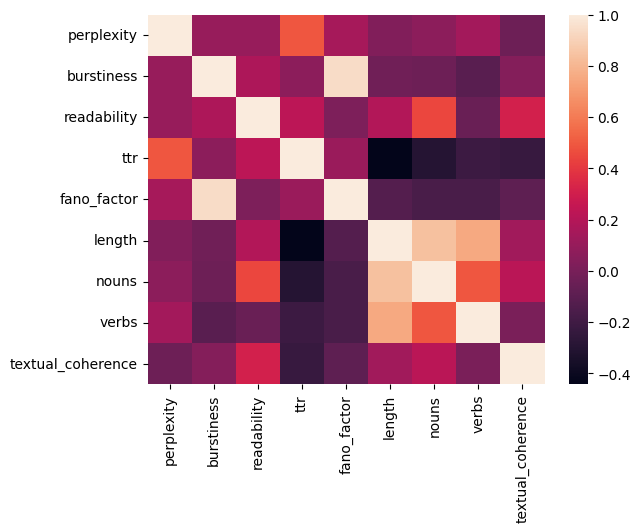

In [15]:
# feature correlation heatmap
import seaborn as sns
sns.heatmap(df[["perplexity", "burstiness", "readability", "ttr", "fano_factor", "length", "nouns", "verbs", "textual_coherence"]].corr())


In [16]:
# run pca to remove the multicollinearity
from sklearn.decomposition import PCA
pca = PCA(n_components=9)
df[["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9"]] = pca.fit_transform(df[["perplexity", "burstiness", "readability", "ttr", "fano_factor", "length", "nouns", "verbs", "textual_coherence"]])
df.drop(columns=["perplexity", "burstiness", "readability", "ttr", "fano_factor", "length", "nouns", "verbs", "textual_coherence"], inplace=True)
df.head(3)

,creative_scenario_round_4,complexity_aggregrate,difficulty_aggregrate,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9
0,Noah is a high school student who loves to gar...,3,2,0.902315,1.137995,-1.248845,-1.544131,0.044594,-1.329719,0.402899,0.374946,0.124163
1,Amy is a barista at Lily's Cafe. She has been ...,2,2,-1.047944,0.545851,-1.228639,-0.583514,0.706368,-0.965097,0.315284,-0.021632,0.030326
2,Amy works at Lily's Cafe. She has been working...,2,3,-0.039797,-1.079711,-0.820470,-0.878606,0.487810,-0.285877,0.963037,-0.516643,0.046672


In [6]:
# perform further feature selection
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
# X = df[["perplexity", "burstiness", "readability", "ttr", "fano_factor", "length", "nouns", "verbs", "textual_coherence"]].to_numpy()
# X = df[["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9"]].to_numpy()

y_complexity = df["complexity_aggregrate"].to_numpy()
y_difficulty = df["difficulty_aggregrate"].to_numpy()

# sns = SequentialFeatureSelector(LinearRegression(), n_features_to_select=5, cv=10).fit(X, y_complexity)

# X = sns.transform(X)

In [69]:
# perform oversampling
from imblearn.over_sampling import BorderlineSMOTE, RandomOverSampler
X, y_complexity = RandomOverSampler().fit_resample(X, y_complexity)

In [14]:
# save the pre-computed features
# df.to_csv("/home/aml7990/Code/creativity-item-generation/item_evaluation/linear_regression/llama-3-8b-instruct-full-set.csv")

In [17]:
import statsmodels.api as sm
import numpy as np
from scipy.stats import bootstrap
from statistics import median
from sklearn.metrics import r2_score

n_samples = 1000
frac = 0.8
train_results = []
test_results = []
metric = "difficulty_aggregrate"
# we use a boostrapping approach to fit a CI on the adjusted r squared
# hold out the data not sampled for testing

for sample in range(n_samples):
    train = df.sample(frac=frac, replace=True)
    test = df[~df.index.isin(train.index)]
    Y_train = train[metric].to_numpy()
    Y_test = test[metric].to_numpy()
    # X = train[["perplexity", "burstiness", "readability", "ttr", "fano_factor", "length", "nouns", "verbs", "textual_coherence"]].to_numpy()
    # X = train[["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9"]].to_numpy()
    X_train = embeddings[train.index]
    X_test = embeddings[test.index]
    
    X_train = sm.add_constant(X_train)
    clf = sm.OLS(Y_train, X_train).fit()
    train_results.append(clf.rsquared_adj)
    X_test = sm.add_constant(X_test)
    ypred = clf.predict(X_test)
    test_results.append(r2_score(Y_test, ypred))
    del clf


# calculate 95% bootstrapped confidence interval for median
bootstrap_ci = bootstrap((train_results,), np.median, confidence_level=0.95, random_state=1, method='percentile')
bootstrap_ci_test = bootstrap((test_results,), np.median, confidence_level=0.95, random_state=1, method='percentile')

print("Train:")
print(bootstrap_ci.confidence_interval)
print(median(train_results))
print("Test:")
print(bootstrap_ci_test.confidence_interval)
print(median(test_results))




# [["perplexity", "readability", "ttr", "fano_factor"]]



Train:
ConfidenceInterval(low=1.0, high=1.0)
1.0
Test:
ConfidenceInterval(low=-0.6763198259454599, high=-0.6268251312504658)
-0.6451816679859943


In [16]:
df.head(3)

,creative_scenario_round_4,complexity_aggregrate,difficulty_aggregrate,perplexity,burstiness,fano_factor,readability,ttr,length,nouns,verbs
0,Noah is a high school student who loves to gar...,0.644622,0.092881,-0.781108,1.061222,1.131066,-0.784694,-0.112595,0.732354,0.373123,1.943979
1,Amy is a barista at Lily's Cafe. She has been ...,-0.623828,0.092881,-0.565861,0.974678,1.068521,-1.012084,0.175056,-0.352513,-0.950590,0.398592
2,Amy works at Lily's Cafe. She has been working...,-0.623828,1.509317,-0.708742,-0.423512,-0.101421,-1.745634,0.058270,0.467752,-0.399043,0.089514


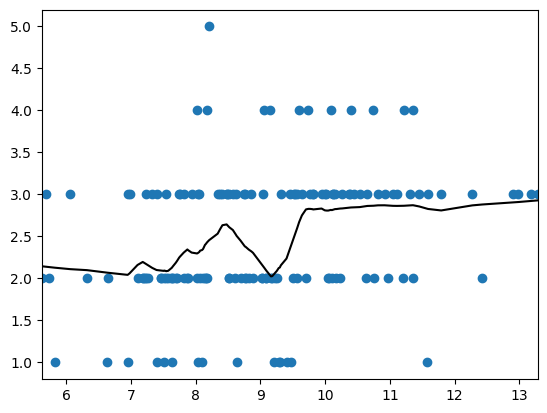

In [18]:
# try nonparametric regression
import pylab
import statsmodels.api as sm
frac = 0.8
metric = "complexity_aggregrate"
train = df.sample(frac=frac, replace=False)
test = df[~df.index.isin(train.index)]
Y_train = train[metric].to_numpy()
Y_test = test[metric].to_numpy()
X_train = train["readability"].to_numpy()
X_test = test["readability"].to_numpy()
smoothed = sm.nonparametric.lowess(exog=X_train, endog=Y_train, frac=0.2)

fig, ax = pylab.subplots()

ax.scatter(X_train, Y_train)
ax.plot(smoothed[:, 0], smoothed[:, 1], c="k")
pylab.autoscale(enable=True, axis="x", tight=True)

In [57]:
# RERUN the FEATURE SELECTION CELL!
import numpy as np
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import KFold
from statistics import median
from matplotlib import pyplot as plt

from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score
from sklearn.utils.fixes import parse_version

# gradient boosting params
params = {
    "n_estimators": 100,
    "max_depth": 4,
    "min_samples_split": 5,
    # "learning_rate": 0.01,
    # "loss": "squared_error",
}

# X = df[["pca_1", "pca_2", "pca_3", "pca_4", "pca_5", "pca_6", "pca_7", "pca_8", "pca_9"]].to_numpy()
X = embeddings

# model = ExtraTreesRegressor(**params)
clf = LinearRegression()
# model = BaggingRegressor(model, bootstrap=False, n_estimators=10)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = []
target = X, y_difficulty
# we use a boostrapping approach to fit a CI on the adjusted r squared

for train, test in kf.split(target[0]):
    X_train = target[0][train]
    Y_train = target[1][train]

    X_test = target[0][test]
    Y_test = target[1][test]
    
    clf.fit(X_train, Y_train)
    results.append(clf.score(X_test, Y_test))


results = pd.DataFrame(results)
print(results.mean())
print(results.min())
print(results.max())



0   -1.354198
dtype: float64
0   -3.536765
dtype: float64
0   -0.122005
dtype: float64


Look at embeddings of items

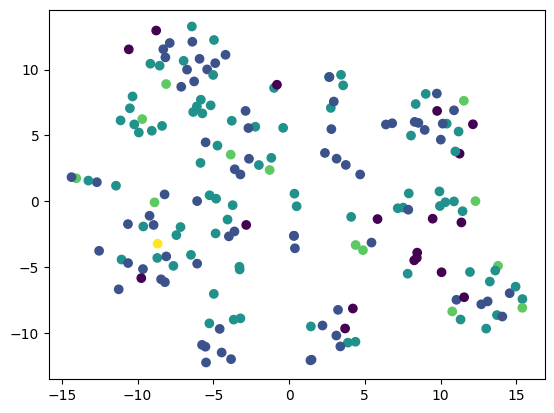

In [22]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(embeddings)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["complexity_aggregrate"])
# plt.legend(df["complexity_aggregrate"].unique())
plt.show()

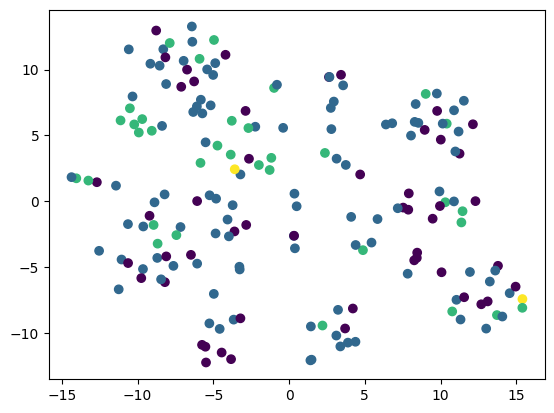

In [23]:
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

tsne = TSNE(n_components=2, random_state=0)
X_tsne = tsne.fit_transform(embeddings)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=df["difficulty_aggregrate"])
# plt.legend(df["complexity_aggregrate"].unique())
plt.show()

In [30]:
from sklearn.metrics import silhouette_score
silhouette_score(embeddings, df["complexity_aggregrate"], metric='cosine')

-0.16012104311794753

In [31]:
silhouette_score(embeddings, df["difficulty_aggregrate"], metric='cosine')

-0.08240831569386686